In [ ]:
import numpy as np  # Importing NumPy library for numerical operations
import pandas as pd  # Importing Pandas library for data manipulation and analysis
import matplotlib.pyplot as plt  # Importing Matplotlib library for data visualization

from matplotlib import style  # Importing the style module from Matplotlib to customize plots


In [ ]:

!pip install nltk  # Installing the Natural Language Toolkit (nltk) library

import re  # Importing the regular expressions library for text preprocessing
import nltk  # Importing the nltk library for natural language processing

# Downloading necessary nltk datasets and tools
nltk.download('stopwords')  # Downloading stopwords for removing common words
nltk.download('punkt_tab')  # Downloading tokenizer table for word tokenization
nltk.download('punkt')  # Downloading tokenizer model for word tokenization
nltk.download('wordnet')  # Downloading WordNet for lemmatization
nltk.download('omw-1.4')  # Downloading WordNet's multilingual resources
nltk.download('averaged_perceptron_tagger')  # Downloading POS tagger

from nltk.corpus import stopwords  # Importing stopwords for removing unnecessary words
from sklearn.model_selection import train_test_split  # Importing for splitting dataset
from nltk.stem import WordNetLemmatizer  # Importing WordNet lemmatizer for text normalization
from wordcloud import WordCloud  # Importing WordCloud for generating word clouds

# Libraries for building the model
from tensorflow.keras.preprocessing.text import Tokenizer  # Importing tokenizer for text preprocessing
from tensorflow.keras.preprocessing.sequence import pad_sequences  # Importing for padding text sequences
from tensorflow.keras.models import Sequential  # Importing Sequential API to define model architecture
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout  # Importing necessary layers

from keras.utils import to_categorical  # Importing for one-hot encoding labels
from keras import backend as K  # Importing backend operations for Keras





[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


In [ ]:
import pandas as pd
data = pd.read_csv("/content/train2.csv")

data.head()

,count,hate_speech_count,offensive_language_count,neither_count,class,tweet
0,3,0,0,3,2,!!! RT @mayasolovely: As a woman you shouldn't...
1,3,0,3,0,1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...
2,3,0,3,0,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...
3,3,0,2,1,1,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...
4,6,0,6,0,1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...


In [ ]:


print(f"num of tweets: {data.shape}")

# extract the text and labels
tweet = list(data['tweet'])
labels = list(data['class'])

num of tweets: (24783, 6)


In [4]:
import numpy as np
import pandas as pd
import re
import nltk
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Bidirectional, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from keras.utils import to_categorical
from sklearn.metrics import precision_score, recall_score, f1_score, classification_report

# Download necessary NLTK resources
nltk.download('punkt')
nltk.download('stopwords')


# Function to preprocess the text data
def preprocess(datas):
    # Download 'punkt_tab' within the function:
    nltk.download('punkt_tab')

    stop_words = set(stopwords.words('english'))
    stop_words.add("rt")  # Add "rt" (retweet abbreviation) to the stop words list

    # ... (rest of your preprocess function remains the same) # Add "rt" (retweet abbreviation) to the stop words list

    def remove_entity(raw_text):
        return re.sub(r"&[^\s;]+;", "", raw_text)

    def change_user(raw_text):
        return re.sub(r"@([^ ]+)", "user", raw_text)

    def remove_url(raw_text):
        return re.sub(r"http\S+|www\S+|https\S+", '', raw_text, flags=re.MULTILINE)

    def remove_noise_symbols(raw_text):
        return re.sub(r'[!"\'#$%&()*+,-./:;<=>?@[\\]^_`{|}~]', '', raw_text)

    def remove_stopwords(raw_text):
        tokens = nltk.word_tokenize(raw_text)
        filtered_words = [word for word in tokens if word.lower() not in stop_words]
        return " ".join(filtered_words)

    clean = [change_user(text) for text in datas]
    clean = [remove_entity(text) for text in clean]
    clean = [remove_url(text) for text in clean]
    clean = [remove_noise_symbols(text) for text in clean]
    clean = [remove_stopwords(text) for text in clean]
    return clean

# Load dataset
data = pd.read_csv("/content/train2.csv")
tweets = list(data['tweet'])
labels = list(data['class'])

# Preprocess the text data
clean_tweets = preprocess(tweets)

# Tokenize and pad sequences
tokenizer = Tokenizer()
tokenizer.fit_on_texts(clean_tweets)
sequences = tokenizer.texts_to_sequences(clean_tweets)
word_index = tokenizer.word_index

max_sequence_length = 100
X_data = pad_sequences(sequences, maxlen=max_sequence_length)
y_data = to_categorical(labels, num_classes=3)

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size=0.2, random_state=42)

# Model Definition
model = Sequential([
    Embedding(input_dim=len(word_index) + 1, output_dim=100, input_length=max_sequence_length),  # Using random embeddings
    Bidirectional(LSTM(128, dropout=0.2, recurrent_dropout=0.2)),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(3, activation='softmax')  # Multi-class classification
])

# Compile the model
model.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=0.001), metrics=['accuracy'])

# Train the model
model.fit(X_train, y_train, epochs=5, batch_size=64, validation_data=(X_test, y_test), verbose=2)

# Evaluate the model
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

# Predictions and Metrics
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test, axis=1)

precision = precision_score(y_true_classes, y_pred_classes, average='weighted')
recall = recall_score(y_true_classes, y_pred_classes, average='weighted')
f1 = f1_score(y_true_classes, y_pred_classes, average='weighted')

print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1-score: {f1}")
print("Classification Report:\n", classification_report(y_true_classes, y_pred_classes))



[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


Epoch 1/5


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


310/310 - 112s - 363ms/step - accuracy: 0.8475 - loss: 0.4503 - val_accuracy: 0.8929 - val_loss: 0.3279
Epoch 2/5
310/310 - 134s - 434ms/step - accuracy: 0.9141 - loss: 0.2677 - val_accuracy: 0.8911 - val_loss: 0.3118
Epoch 3/5
310/310 - 140s - 452ms/step - accuracy: 0.9365 - loss: 0.1855 - val_accuracy: 0.8848 - val_loss: 0.3399
Epoch 4/5
310/310 - 146s - 470ms/step - accuracy: 0.9562 - loss: 0.1305 - val_accuracy: 0.8765 - val_loss: 0.4076
Epoch 5/5
310/310 - 135s - 437ms/step - accuracy: 0.9684 - loss: 0.0942 - val_accuracy: 0.8782 - val_loss: 0.4925
155/155 ━━━━━━━━━━━━━━━━━━━━ 8s 54ms/step - accuracy: 0.8802 - loss: 0.4730
Test Loss: 0.49251383543014526
Test Accuracy: 0.8781521320343018
155/155 ━━━━━━━━━━━━━━━━━━━━ 8s 51ms/step
Precision: 0.86671177840207
Recall: 0.8781521081299173
F1-score: 0.871602505113657
Classification Report:
               precision    recall  f1-score   support

           0       0.35      0.23      0.27       290
           1       0.92      0.94      0.

In [7]:
# Preprocess the tweets

clean_tweet = preprocess(tweets)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(clean_tweet, labels, test_size=0.2, random_state=42)

# Now you can proceed with tokenization and padding
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

vocab_size = len(tokenizer.word_index) + 1

# Calculate max_length
max_length = max(len(seq) for seq in X_train)

# to test an outlier case (if one of the test dataset has longer length)
for x in X_test:
    if len(x) > max_length:
        print(f"an outlier detected: {x}")

X_train = pad_sequences(X_train, maxlen=max_length)
X_test = pad_sequences(X_test, maxlen=max_length)



[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


In [8]:
y_test = to_categorical(y_test, num_classes=3)
y_train = to_categorical(y_train, num_classes=3)

In [9]:
print(f"num test tweet: {y_test.shape[0]}")
print(f"num train tweet: {y_train.shape[0]}")

num test tweet: 4957
num train tweet: 19826


In [10]:
def recall(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1(y_true, y_pred):
    precisions = precision(y_true, y_pred)
    recalls = recall(y_true, y_pred)
    return 2*((precisions*recalls)/(precisions+recalls+K.epsilon()))

In [11]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
import numpy as np

# Parameters
vocab_size = 18330  # Vocabulary size
embedding_dim = 128  # Embedding dimensions
max_length = 27  # Max length of sequences

# Define the Model
model = Sequential([
    Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_length),  # Embedding Layer
    LSTM(64, return_sequences=False),  # LSTM Layer
    Dropout(0.5),                      # Dropout Layer
    Dense(64, activation='relu'),      # Fully Connected Dense Layer
    Dropout(0.5),                      # Dropout Layer
    Dense(3, activation='softmax')     # Output Layer with 3 Classes
])

#Compile the Model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])


print("Step 3: Create Dummy Input Data")
X_sample = np.random.randint(1, vocab_size, size=(1, max_length))  # 1 sample, padded to max_length
print("X_sample Shape:", X_sample.shape)

#Build the Model by Passing Input Data
print("Step 4: Predict to Build the Model")
try:
    _ = model.predict(X_sample)
    print("Prediction Success! Model is now built.")
except Exception as e:
    print(f"Error during prediction: {e}")

#  Recheck the Summary
print("Step 5: Updated Model Summary:")
model.summary()







/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Step 3: Create Dummy Input Data
X_sample Shape: (1, 27)
Step 4: Predict to Build the Model
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 452ms/step
Prediction Success! Model is now built.
Step 5: Updated Model Summary:


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)              │ (1, 27, 128)                │       2,346,240 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (1, 64)                     │          49,408 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (1, 64)                     │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (1, 64)                     │           4,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (1, 64)                     │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (1, 3)                      │             195 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,400,003 (9.16 MB)

 Trainable params: 2,400,003 (9.16 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


310/310 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7579 - loss: 0.8139 - val_accuracy: 0.7866 - val_loss: 0.6065
Epoch 2/10
310/310 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.7921 - loss: 0.6284 - val_accuracy: 0.8037 - val_loss: 0.5937
Epoch 3/10
310/310 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8006 - loss: 0.6160 - val_accuracy: 0.8043 - val_loss: 0.5895
Epoch 4/10
310/310 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.7987 - loss: 0.6099 - val_accuracy: 0.8061 - val_loss: 0.5875
Epoch 5/10
310/310 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8010 - loss: 0.6122 - val_accuracy: 0.8057 - val_loss: 0.5871
Epoch 6/10
310/310 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8011 - loss: 0.6052 - val_accuracy: 0.8057 - val_loss: 0.5860
Epoch 7/10
310/310 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8002 - loss: 0.6051 - val_accuracy: 0.8057 - val_loss: 0.5863
Epoch 8/10
310/310 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8055 - loss: 0.5959 - val_accuracy: 0.8055 - val_

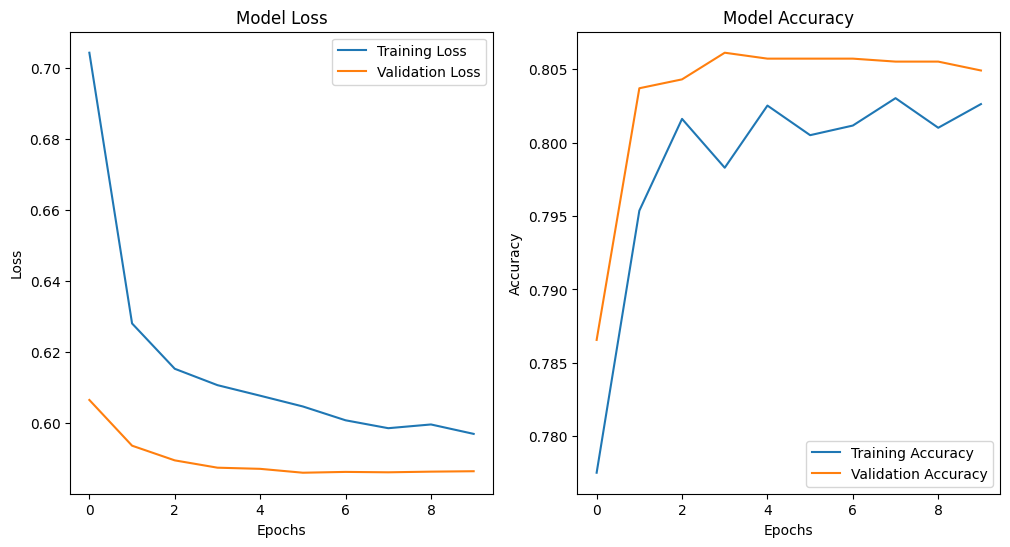

Epoch 1/10
310/310 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8004 - loss: 0.5976 - val_accuracy: 0.8049 - val_loss: 0.5865
Epoch 2/10
310/310 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8024 - loss: 0.5953 - val_accuracy: 0.8055 - val_loss: 0.5862
Epoch 3/10
310/310 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8016 - loss: 0.5981 - val_accuracy: 0.8049 - val_loss: 0.5859
Epoch 4/10
310/310 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8010 - loss: 0.5990 - val_accuracy: 0.8055 - val_loss: 0.5867
Epoch 5/10
310/310 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7984 - loss: 0.5979 - val_accuracy: 0.8049 - val_loss: 0.5866
Epoch 6/10
310/310 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7984 - loss: 0.6004 - val_accuracy: 0.8055 - val_loss: 0.5867
Epoch 7/10
310/310 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7985 - loss: 0.5967 - val_accuracy: 0.8049 - val_loss: 0.5865
Epoch 8/10
310/310 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.7989 - loss: 0.6046 - val_accuracy: 0.

In [15]:
!pip install tensorflow # install the tensorflow library if it is not installed
import matplotlib.pyplot as plt

import tensorflow as tf  # Importing TensorFlow library for deep learning
from sklearn.model_selection import train_test_split  # Import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical # Import to_categorical for one-hot encoding


# Build a simple model (a dense network for classification)
X_train, X_test, y_train, y_test = train_test_split(clean_tweet, data['class'], test_size=0.2, random_state=42)

# Text vectorization using TF-IDF with 100 features
vectorizer = TfidfVectorizer(stop_words='english', max_features=100)
X_train_tfidf = vectorizer.fit_transform(X_train).toarray()
X_test_tfidf = vectorizer.transform(X_test).toarray()


max_len = 100  # Maximum sequence length
X_train_padded = pad_sequences(X_train_tfidf, maxlen=max_len) # Define X_train_padded here
X_test_padded = pad_sequences(X_test_tfidf, maxlen=max_len)  # Define X_test_padded here
# Build a simple model (a dense network for classification)
model = tf.keras.Sequential([
    tf.keras.layers.InputLayer(input_shape=(X_train_padded.shape[1],)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(3, activation='softmax')  # 3 output units with softmax for multi-class classification
])

# One-hot encode your target labels
y_train = to_categorical(y_train, num_classes=3) # Convert y_train to one-hot encoding
y_test = to_categorical(y_test, num_classes=3)  # Convert y_test to one-hot encoding

# Compile the model with appropriate loss and metrics for multi-class classification
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
# Train the model
model_history = model.fit(X_train_padded, y_train, epochs=10, batch_size=64, validation_data=(X_test_padded, y_test), verbose=1)

# Evaluate the model
loss, accuracy = model.evaluate(X_test_padded, y_test)
print(f"Test Loss: {loss}, Test Accuracy: {accuracy}")



# Plot the training history (loss and accuracy)
plt.figure(figsize=(12, 6))

# Plot loss
plt.subplot(1, 2, 1)
plt.plot(model_history.history['loss'], label='Training Loss')
plt.plot(model_history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plot accuracy
plt.subplot(1, 2, 2)
plt.plot(model_history.history['accuracy'], label='Training Accuracy')
plt.plot(model_history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

model_history = model.fit(
    X_train_padded,  # Use X_train_padded here
    y_train,
    batch_size = 64,
    epochs=10,
    validation_data=(X_test_padded, y_test)  # Use X_test_padded here
)

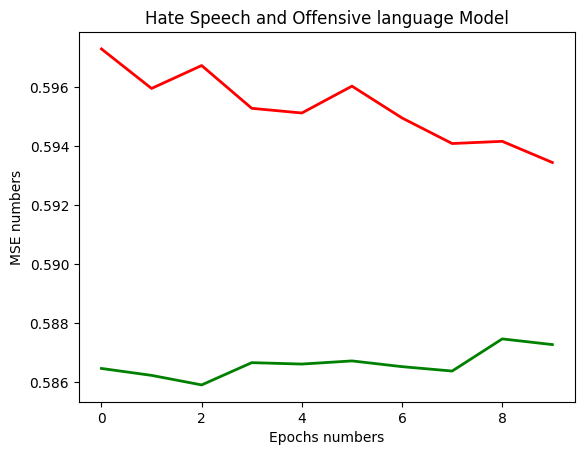

In [16]:
import matplotlib.pyplot as plt
hist = model.history.history
plt.plot(hist['loss'],'r',linewidth=2, label='Training loss')
plt.plot(hist['val_loss'], 'g',linewidth=2, label='Validation loss')
plt.title('Hate Speech and Offensive language Model')
plt.xlabel('Epochs numbers')
plt.ylabel('MSE numbers')
plt.show()

Epoch 1/5


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


310/310 ━━━━━━━━━━━━━━━━━━━━ 31s 93ms/step - accuracy: 0.7594 - loss: 0.7350 - val_accuracy: 0.7730 - val_loss: 0.6651
Epoch 2/5
310/310 ━━━━━━━━━━━━━━━━━━━━ 42s 96ms/step - accuracy: 0.7740 - loss: 0.6754 - val_accuracy: 0.7730 - val_loss: 0.6537
Epoch 3/5
310/310 ━━━━━━━━━━━━━━━━━━━━ 28s 92ms/step - accuracy: 0.7802 - loss: 0.6466 - val_accuracy: 0.7971 - val_loss: 0.6230
Epoch 4/5
310/310 ━━━━━━━━━━━━━━━━━━━━ 42s 95ms/step - accuracy: 0.7892 - loss: 0.6413 - val_accuracy: 0.7971 - val_loss: 0.6225
Epoch 5/5
310/310 ━━━━━━━━━━━━━━━━━━━━ 41s 95ms/step - accuracy: 0.7927 - loss: 0.6344 - val_accuracy: 0.7971 - val_loss: 0.6211


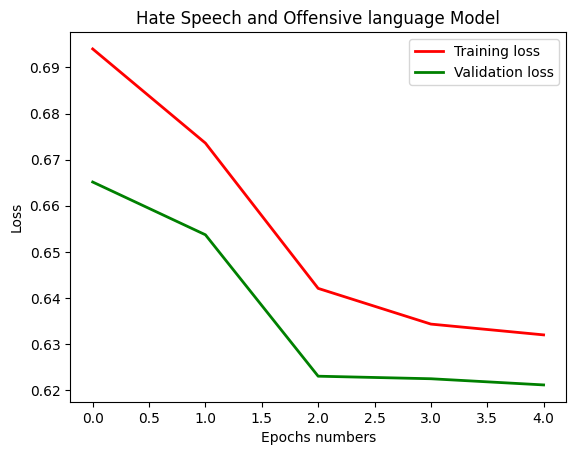

In [17]:
# Get unique labels (assuming 'labels' is a list of your labels)
unique_labels = np.unique(labels)

# Count the occurrences of each label
counts = [np.sum(np.array(labels) == label) for label in unique_labels]


labels_expanded = np.repeat(unique_labels, counts)

data = pd.read_csv("/content/train2.csv")
X_train, X_test, y_train, y_test = train_test_split(clean_tweet, data['class'], test_size=0.2, random_state=42)

# Text vectorization using TF-IDF with 100 features
vectorizer = TfidfVectorizer(stop_words='english', max_features=100)  # Set max_features to 100
X_train_tfidf = vectorizer.fit_transform(X_train).toarray()
X_test_tfidf = vectorizer.transform(X_test).toarray()

# Pad sequences (if using LSTM) - adjust if not needed
max_len = 100  # Maximum sequence length
X_train_padded = pad_sequences(X_train_tfidf, maxlen=max_len)
X_test_padded = pad_sequences(X_test_tfidf, maxlen=max_len)

# Convert labels to categorical (one-hot encoding)
y_train = to_categorical(y_train, num_classes=3)
y_test = to_categorical(y_test, num_classes=3)


# Define your model
model = Sequential([
    # Embedding layer (adjust input_dim and output_dim if needed)
    Embedding(10000, 100, input_length=max_len),
    # LSTM layer
    LSTM(64, dropout=0.3, recurrent_dropout=0.3),
    # Dropout layer
    Dropout(0.5),
    # Dense layer
    Dense(128, activation="relu"),
    # Dropout layer
    Dropout(0.5),
    # Output layer
    Dense(3, activation="softmax")
])


# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
model_history = model.fit(
    X_train_padded,  # Use X_train_padded
    y_train,
    batch_size=64,
    epochs=5,
    validation_data=(X_test_padded, y_test)  # Use X_test_padded
)

# Plot the loss values
hist = model_history.history
plt.plot(hist['loss'], 'r', linewidth=2, label='Training loss')
plt.plot(hist['val_loss'], 'g', linewidth=2, label='Validation loss')
plt.title('Hate Speech and Offensive language Model')
plt.xlabel('Epochs numbers')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [18]:

!pip install keras-tuner  # Install the keras-tuner package

from keras_tuner import Hyperband  # Now you can import Hyperband
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dropout, Dense
from tensorflow.keras.optimizers import Adam

# Define num_classes here, outside the function
num_classes = 3  # 3 classes (0, 1, 2)



# Split the dataset into training and testing sets
# Replace the problematic line:
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
# With the following line:
X_train, X_test, y_train, y_test = train_test_split(clean_tweet, data['class'], test_size=0.2, random_state=42)

# The variable 'clean_tweet' likely holds your preprocessed text data
# The variable 'data['class']' likely holds your labels

# Preprocess the training and testing data
X_train = preprocess(X_train)
X_test = preprocess(X_test)
# Text vectorization using TF-IDF
vectorizer = TfidfVectorizer(stop_words='english', max_features=5000)
X_train_tfidf = vectorizer.fit_transform(X_train).toarray() # Convert text to numerical features
X_test_tfidf = vectorizer.transform(X_test).toarray()      # Convert text to numerical features


# Convert data to NumPy arrays and ensure proper dtype
X_train = np.asarray(X_train_tfidf).astype('float32')  # Use X_train_tfidf, not X_train
X_test = np.asarray(X_test_tfidf).astype('float32')   # Use X_test_tfidf, not X_test
y_train = np.asarray(y_train).astype('float32')
y_test = np.asarray(y_test).astype('float32')


# Build a simple model (a dense network for classification)
model = tf.keras.Sequential([
    tf.keras.layers.Dense(10, activation='relu', input_shape=(784,)),
])

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 2.5 MB/s eta 0:00:00


[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [20]:

# Define num_classes here, outside the function
num_classes = 3  # 3 classes (0, 1, 2)

def build_model(hp):
    model = Sequential([
        Embedding(input_dim=10000, output_dim=hp.Int('embedding_dim', min_value=32, max_value=128, step=32), input_length=max_length),
        LSTM(hp.Int('lstm_units', min_value=64, max_value=256, step=64), return_sequences=True),
        Dropout(hp.Float('dropout_rate', 0.2, 0.5, step=0.1)),
        Dense(hp.Int('dense_units', min_value=16, max_value=64, step=16), activation='relu'),
        Dense(num_classes, activation='softmax')  # Now num_classes is accessible
    ])
    model.compile(optimizer=Adam(hp.Choice('learning_rate', [1e-2, 1e-3, 1e-4])), loss='categorical_crossentropy', metrics=['accuracy'])
    return model

tuner = Hyperband(build_model, objective='val_accuracy', max_epochs=10, factor=3, directory='tuner_dir', project_name='hate_speech')


In [21]:
!pip install tensorflow # install the tensorflow library if it is not installed
import tensorflow as tf  # Importing TensorFlow library for deep learning
from sklearn.model_selection import train_test_split  # Import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from tensorflow.keras.preprocessing.sequence import pad_sequences


# Build a simple model (a dense network for classification)
X_train, X_test, y_train, y_test = train_test_split(clean_tweet, data['class'], test_size=0.2, random_state=42)

# Text vectorization using TF-IDF with 100 features
vectorizer = TfidfVectorizer(stop_words='english', max_features=100)
X_train_tfidf = vectorizer.fit_transform(X_train).toarray()
X_test_tfidf = vectorizer.transform(X_test).toarray()


max_len = 100  # Maximum sequence length
X_train_padded = pad_sequences(X_train_tfidf, maxlen=max_len) # Define X_train_padded here
X_test_padded = pad_sequences(X_test_tfidf, maxlen=max_len)  # Define X_test_padded here
# Build a simple model (a dense network for classification)
model = tf.keras.Sequential([
    tf.keras.layers.InputLayer(input_shape=(X_train_padded.shape[1],)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1, activation='sigmoid')  # Sigmoid for binary classification
])

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
model_history = model.fit(X_train_padded, y_train, epochs=10, batch_size=64, validation_data=(X_test_padded, y_test), verbose=1)

# Evaluate the model
loss, accuracy = model.evaluate(X_test_padded, y_test)
print(f"Test Loss: {loss}, Test Accuracy: {accuracy}")
# Evaluate the model on the training set
train_loss, train_accuracy = model.evaluate(X_train_padded, y_train, verbose=0)
print(f"Training Loss: {train_loss}, Training Accuracy: {train_accuracy}")


def predict_hate_speech(text):
    # Preprocess the input text
    processed_text = preprocess([text])

    # Tokenize the processed text (Assuming you have used Tokenizer during training)
    tokenizer = Tokenizer(num_words=10000)
    tokenizer.fit_on_texts(processed_text)
    sequences = tokenizer.texts_to_sequences(processed_text)

    # Pad the sequences to the same length
    max_length = 100  # Adjust according to your model's input length
    padded_sequences = pad_sequences(sequences, maxlen=max_length)

    # Predict with the model
    prediction = model.predict(padded_sequences)

    # Assuming binary classification (0: Non-hate, 1: Hate speech)
    if prediction >= 0.5:
        return "Hate Speech"
    else:
        return "Non-Hate Speech"

# Test with sample texts
sample_texts = [
    "I hate everyone who disagrees with me!"  # Hate speech
]

# Display results
for text in sample_texts:
    result = predict_hate_speech(text)
    print(f"Text: {text} => Prediction: {result}")

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Epoch 1/10
310/310 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - accuracy: 0.7583 - loss: -0.3613 - val_accuracy: 0.7730 - val_loss: -11.2724
Epoch 2/10
310/310 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.7734 - loss: -27.6755 - val_accuracy: 0.7730 - val_loss: -122.8646
Epoch 3/10
310/310 ━━━━━━━━━━━━━━━━━━━━ 5s 16ms/step - accuracy: 0.7694 - loss: -190.4905 - val_accuracy: 0.7730 - val_loss: -435.9573
Epoch 4/10
310/310 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.7754 - loss: -554.3708 - val_accuracy: 0.7730 - val_loss: -1001.3717
Epoch 5/10
310/310 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7748 - loss: -1228.5833 - val_accuracy: 0.7730 - val_loss: -1900.4878
Epoch 6/10
310/310 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7724 - loss: -2243.3489 - val_accuracy: 0.7730 - val_loss: -3126.7468
Epoch 7/10
310/310 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7701 - loss: -3470.1187 - val_accuracy: 0.7730 - val_loss: -4731.0234
Epoch 8/10
310/310 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accu

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


In [22]:
!pip install nltk
import nltk
nltk.download('punkt_tab')

import numpy as np
import pandas as pd
!pip install tensorflow # install the tensorflow library if it is not installed
import tensorflow as tf  # Importing TensorFlow library for deep learning
from sklearn.model_selection import train_test_split  # Import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import pandas as pd # import pandas for dataframe manipulation
import re # import re for text preprocessing
from nltk.corpus import stopwords # import stopwords for removing stopwords
import nltk

# Download necessary NLTK resources
nltk.download('stopwords')
nltk.download('punkt')


# Preprocessing function
def preprocess(datas):
    stop_words = set(stopwords.words('english'))
    stop_words.add("rt")

    def remove_entity(raw_text):
        return re.sub(r"&[^\s;]+;", "", raw_text)

    def change_user(raw_text):
        return re.sub(r"@([^ ]+)", "user", raw_text)

    def remove_url(raw_text):
        return re.sub(r"http\S+|www\S+|https\S+", '', raw_text, flags=re.MULTILINE)

    def remove_noise_symbols(raw_text):
        return re.sub(r'[!"\'#$%&()*+,-./:;<=>?@[\\]^_`{|}~]', '', raw_text)

    def remove_stopwords(raw_text):
        tokens = nltk.word_tokenize(raw_text)
        filtered_words = [word for word in tokens if word.lower() not in stop_words]
        return " ".join(filtered_words)

    clean = [change_user(text) for text in datas]
    clean = [remove_entity(text) for text in clean]
    clean = [remove_url(text) for text in clean]
    clean = [remove_noise_symbols(text) for text in clean]
    clean = [remove_stopwords(text) for text in clean]
    return clean

# Load the data
data = pd.read_csv("/content/train2.csv")

# Get the tweets column and apply preprocessing
tweets = data['tweet'].tolist() # Assuming "tweet" is the column with the tweet data
clean_tweet = preprocess(tweets) # Apply the preprocessing function to the tweets


# Build a simple model (a dense network for classification)
X_train, X_test, y_train, y_test = train_test_split(clean_tweet, data['class'], test_size=0.2, random_state=42)

# Text vectorization using TF-IDF with 100 features
vectorizer = TfidfVectorizer(stop_words='english', max_features=100)
X_train_tfidf = vectorizer.fit_transform(X_train).toarray()
X_test_tfidf = vectorizer.transform(X_test).toarray()


max_len = 100  # Maximum sequence length
X_train_padded = pad_sequences(X_train_tfidf, maxlen=max_len) # Define X_train_padded here
X_test_padded = pad_sequences(X_test_tfidf, maxlen=max_len)  # Define X_test_padded here
# Build a simple model (a dense network for classification)
model = tf.keras.Sequential([
    tf.keras.layers.InputLayer(input_shape=(X_train_padded.shape[1],)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1, activation='sigmoid')  # Sigmoid for binary classification
])

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
model_history = model.fit(X_train_padded, y_train, epochs=10, batch_size=64, validation_data=(X_test_padded, y_test), verbose=1)

# Evaluate the model
loss, accuracy = model.evaluate(X_test_padded, y_test)
print(f"Test Loss: {loss}, Test Accuracy: {accuracy}")


# Make predictions on new data (example)
sample_text = ["I hate this place", "I love this community"]
sample_tfidf = vectorizer.transform(sample_text).toarray()
sample_padded = pad_sequences(sample_tfidf, maxlen=max_len)

predictions = model.predict(sample_padded)
predicted_labels = (predictions > 0.5).astype(int)  # Convert probabilities to binary labels

# Print predicted labels
print(predicted_labels)





[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Epoch 1/10
310/310 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.7493 - loss: -0.0618 - val_accuracy: 0.7730 - val_loss: -7.7719
Epoch 2/10
310/310 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.7761 - loss: -20.3716 - val_accuracy: 0.7730 - val_loss: -96.8567
Epoch 3/10
310/310 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7781 - loss: -147.5963 - val_accuracy: 0.7730 - val_loss: -356.2508
Epoch 4/10
310/310 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7741 - loss: -458.8563 - val_accuracy: 0.7730 - val_loss: -844.9395
Epoch 5/10
310/310 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7783 - loss: -1048.5083 - val_accuracy: 0.7730 - val_loss: -1601.5090
Epoch 6/10
310/310 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7774 - loss: -1808.2474 - val_accuracy: 0.7730 - val_loss: -2647.5376
Epoch 7/10
310/310 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7747 - loss: -2859.6160 - val_accuracy: 0.7730 - val_loss: -4019.7063
Epoch 8/10
310/310 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
[[1]
 [1]]
